In [2]:
#imports
import os
import json
import pandas as pd
import polars as pl
from utils import list_folders, json_to_dataframe, list_all_files, add_districts


main_folder = 'snapshots'
dates = list_folders(main_folder)
files = list_all_files(main_folder, dates)

#stations_data = json_to_polar_dataframe(files)
stations_data = json_to_dataframe(files)

# Stations master file
#URL: https://opendata-ajuntament.barcelona.cat/data/es/dataset/informacio-estacions-bicing
stations_master_file = main_folder+ '/2024_05_Maig_BicingNou_INFORMACIO.csv'

# Pandas

stations_master = pd.read_csv(stations_master_file, dtype={'post_code': str, 'short_name': str}).sort_values(by='station_id')
stations_master['last_updated'] = pd.to_datetime(stations_master['last_updated'])
stations_master = stations_master.sort_values('last_updated').groupby('station_id').last().reset_index()

stations_master_filtered = stations_master[['short_name', 'post_code', 'capacity']].rename(columns={'short_name': 'station_id'})

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_66715/936224701.py:22: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  stations_master = pd.read_csv(stations_master_file, dtype={'post_code': str, 'short_name': str}).sort_values(by='station_id')


In [8]:
stations_master_filtered = add_districts(stations_master_filtered)
capacity_percent = stations_data[['station_id', 'num_bikes_available', 'timestamp_file']].merge(stations_master_filtered, on='station_id', how='inner')
capacity_percent

,station_id,num_bikes_available,timestamp_file,post_code,capacity,district
0,1,19,1694063435,08013,46.0,Eixample
1,2,14,1694063435,08013,29.0,Eixample
2,3,7,1694063435,08013,27.0,Eixample
3,4,8,1694063435,08013,21.0,Eixample
4,5,3,1694063435,08018,39.0,Sant Martí
...,...,...,...,...,...,...
5129697,515,9,1693689654,08030,24.0,Sant Andreu
5129698,516,12,1693689654,08030,21.0,Sant Andreu
5129699,517,7,1693689654,08033,20.0,Nou Barris
5129700,518,0,1693689654,08032,27.0,Horta-Guinardó


In [9]:
stations_master_filtered = add_districts(stations_master_filtered)

capacity_percent = stations_data[['station_id', 'num_bikes_available', 'timestamp_file']].merge(stations_master_filtered, on='station_id', how='inner')
capacity_percent = capacity_percent.groupby(['timestamp_file', 'district']).agg({
    'capacity': 'sum',
    'num_bikes_available': 'sum'
}).reset_index()
capacity_percent['occupancy'] = capacity_percent['num_bikes_available'] / capacity_percent['capacity']
capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')


capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')
capacity_percent.set_index('timestamp_file', inplace=True)
results = []
for district, group in capacity_percent.groupby('district'):
    group = group.sort_index()
    group['occupancy_sma1h'] = group['occupancy'].rolling(window='1h').mean()
    results.append(group)

capacity_percent = pd.concat(results)
capacity_percent.reset_index(inplace=True)

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_66715/3838973040.py:9: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')


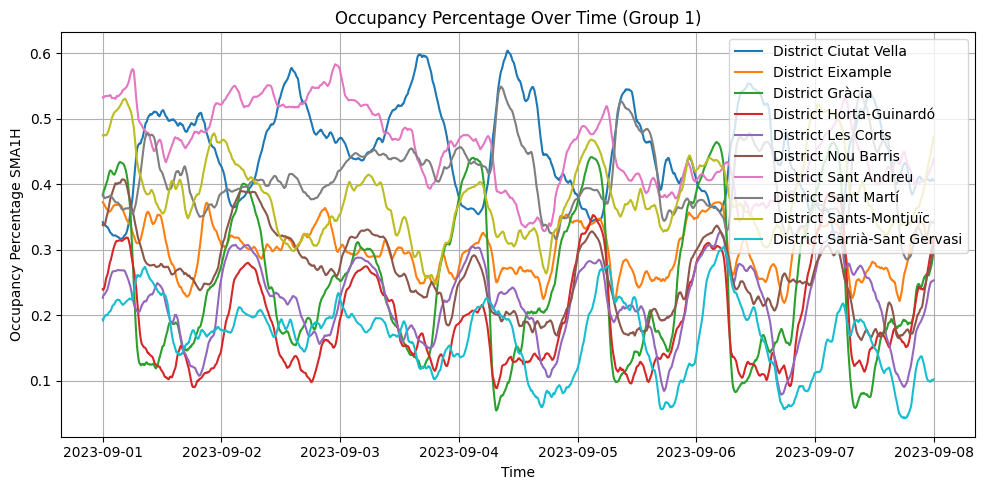

In [12]:
import matplotlib.pyplot as plt

unique_post_codes = capacity_percent['district'].unique()

# Divide in groups of 5
n = 10
post_code_groups = [unique_post_codes[i:i + n] for i in range(0, len(unique_post_codes), n)]


for index, group in enumerate(post_code_groups):
    plt.figure(figsize=(10, 5))  
    data_subset = capacity_percent[capacity_percent['district'].isin(group)]
    for district, data in data_subset.groupby('district'):
        plt.plot(data['timestamp_file'], data['occupancy_sma1h'], label=f'District {district}')

    plt.title(f'Occupancy Percentage Over Time (Group {index + 1})')
    plt.xlabel('Time')
    plt.ylabel('Occupancy Percentage SMA1H')
    plt.legend()
    plt.grid(True)
    #plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
capacity_percent = stations_data[['station_id', 'num_bikes_available', 'timestamp_file']].merge(stations_master_filtered, on='station_id', how='inner')
capacity_percent = capacity_percent.groupby(['timestamp_file', 'post_code']).agg({
    'capacity': 'sum',
    'num_bikes_available': 'sum'
}).reset_index()
capacity_percent['occupancy'] = capacity_percent['num_bikes_available'] / capacity_percent['capacity']
capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')


capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')
capacity_percent.set_index('timestamp_file', inplace=True)
results = []
for post_code, group in capacity_percent.groupby('post_code'):
    group = group.sort_index()
    group['occupancy_sma1h'] = group['occupancy'].rolling(window='1h').mean()
    results.append(group)

capacity_percent = pd.concat(results)
capacity_percent.reset_index(inplace=True)

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_65611/4090861731.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  capacity_percent['timestamp_file'] = pd.to_datetime(capacity_percent['timestamp_file'], unit='s')


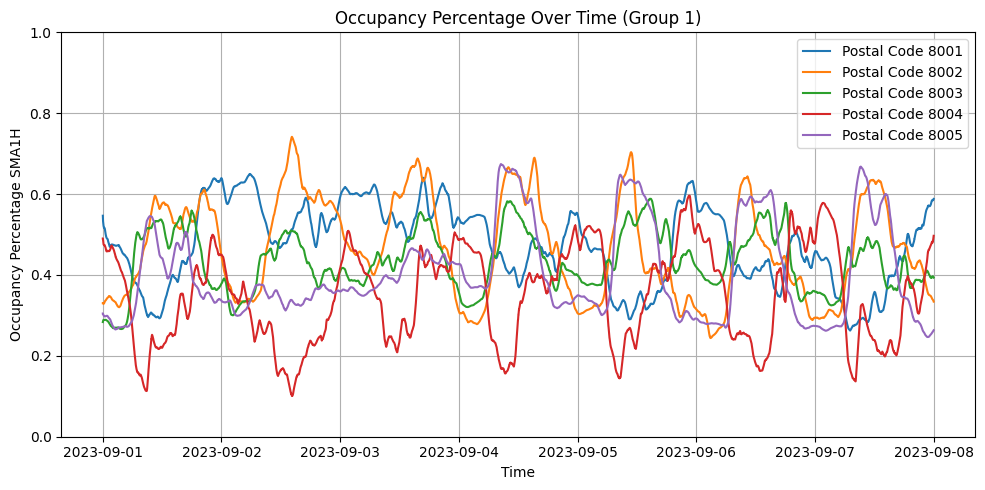

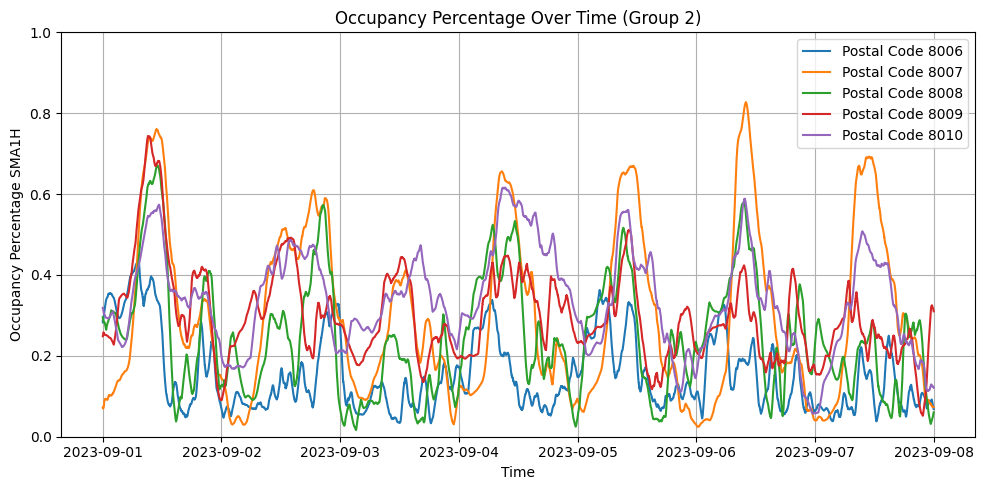

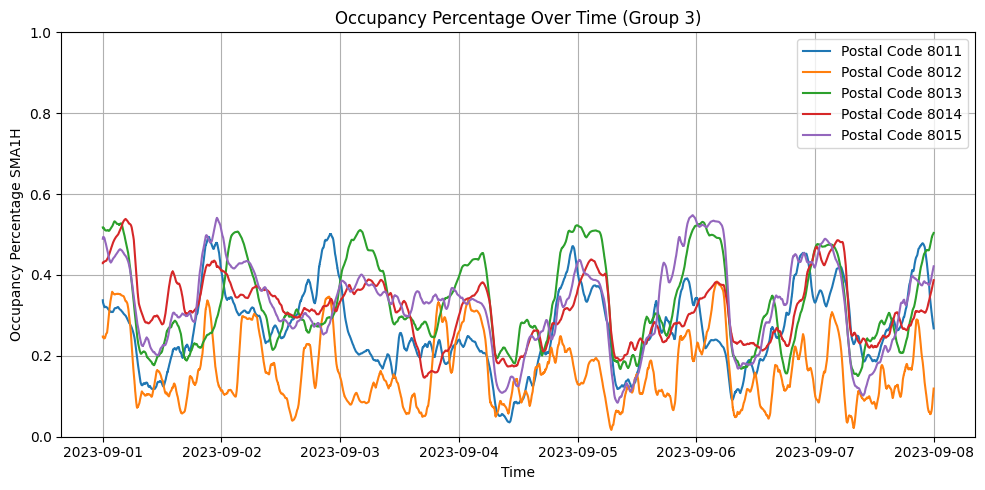

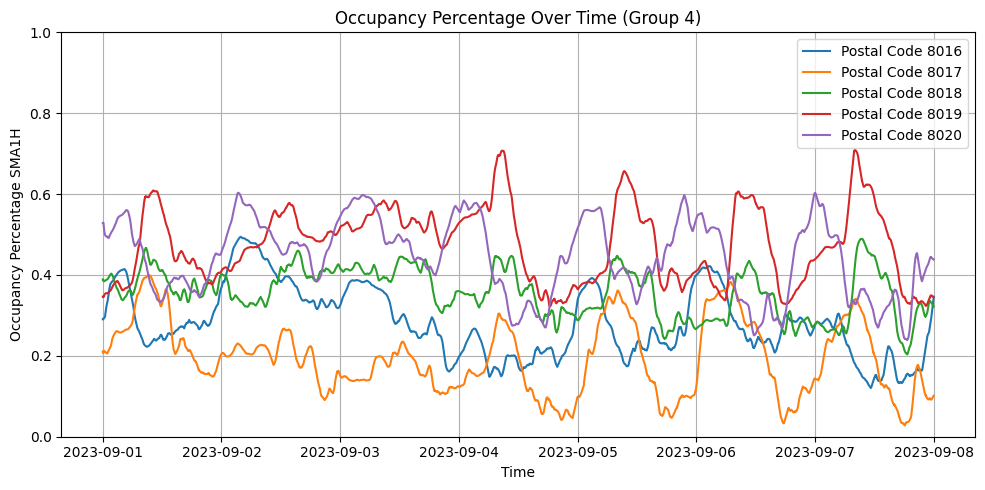

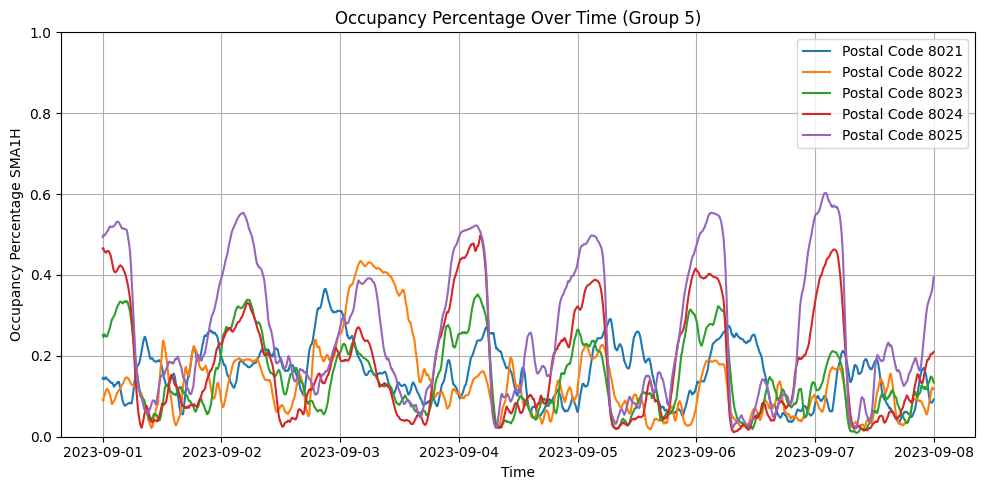

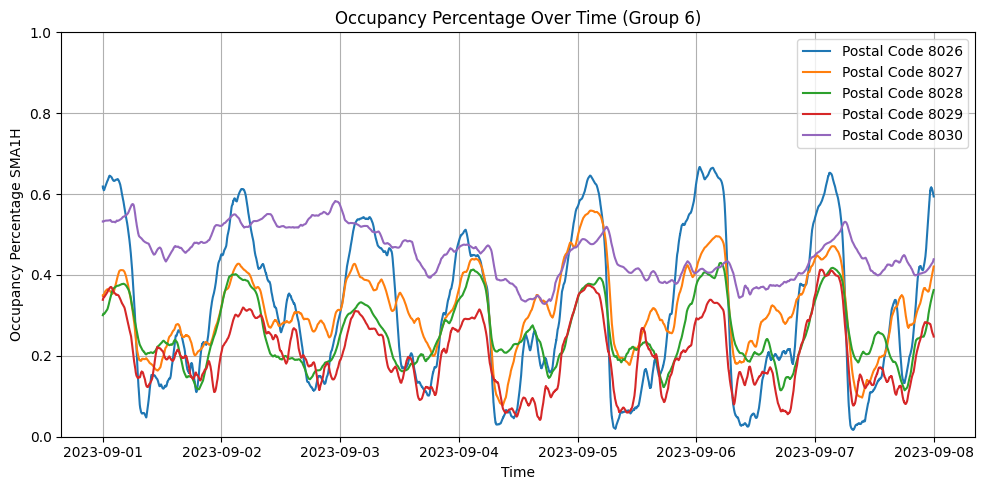

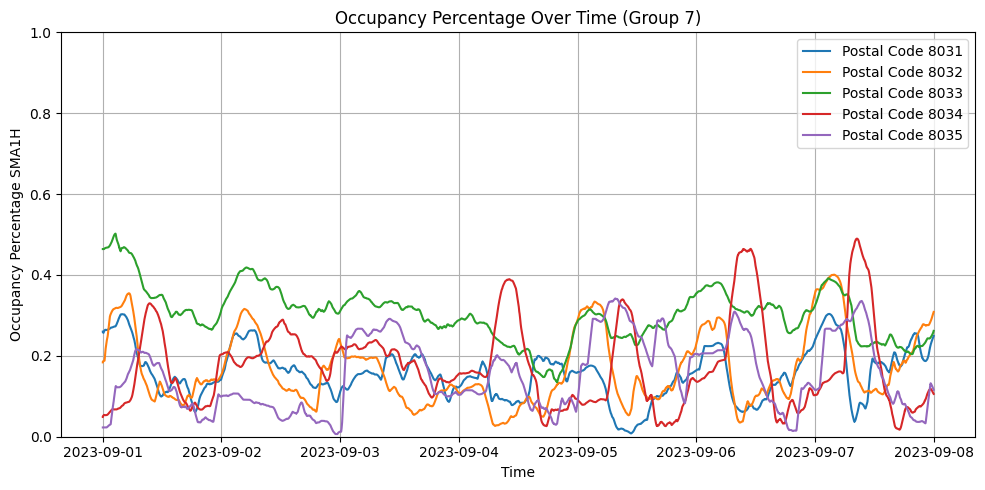

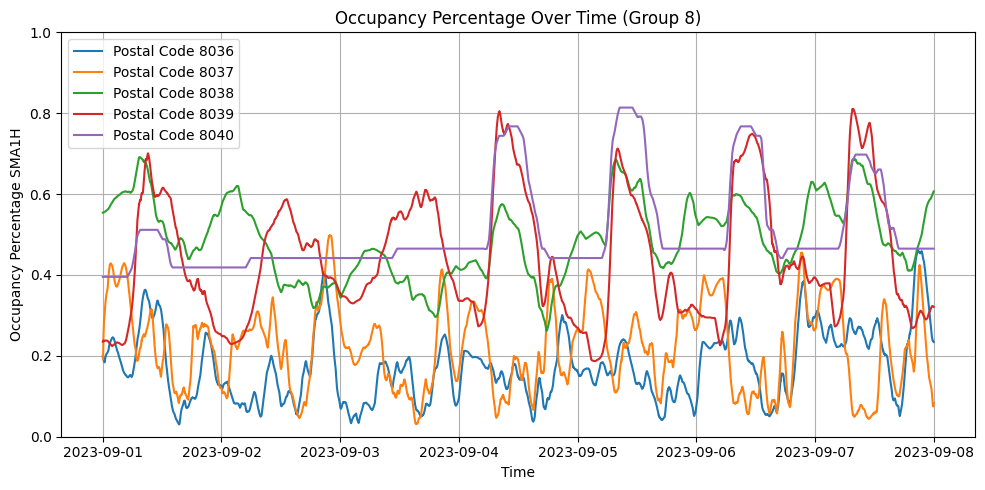

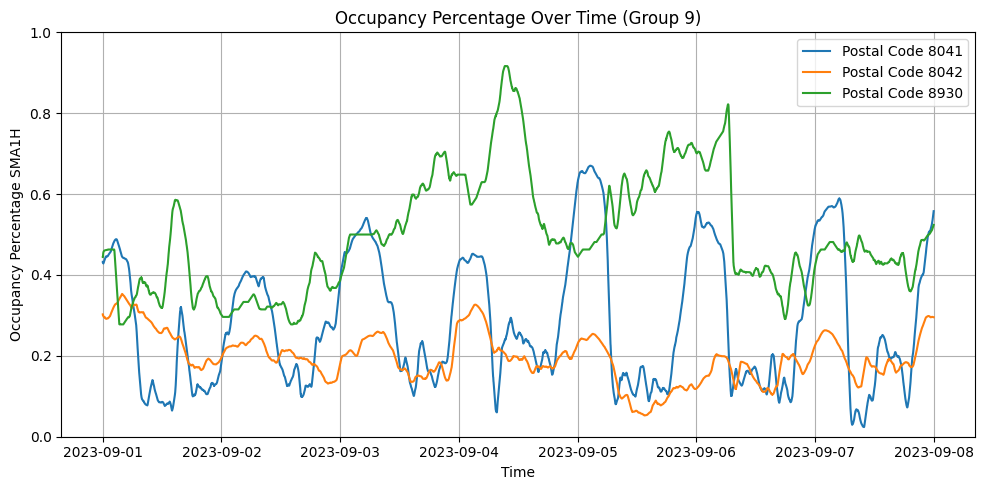

In [ ]:
import matplotlib.pyplot as plt

unique_post_codes = capacity_percent['post_code'].unique()

# Divide in groups of 5
n = 5
post_code_groups = [unique_post_codes[i:i + n] for i in range(0, len(unique_post_codes), n)]


for index, group in enumerate(post_code_groups):
    plt.figure(figsize=(10, 5))  
    data_subset = capacity_percent[capacity_percent['post_code'].isin(group)]
    for post_code, data in data_subset.groupby('post_code'):
        plt.plot(data['timestamp_file'], data['occupancy_sma1h'], label=f'Postal Code {post_code}')

    plt.title(f'Occupancy Percentage Over Time (Group {index + 1})')
    plt.xlabel('Time')
    plt.ylabel('Occupancy Percentage SMA1H')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()